In [1]:
import torch
import random
from time import sleep
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

class Consts:
    random.seed(42)
    block_size = 4  # Kontextová délka: kolik znaků použijeme k předpovědi dalšího?
    num_layers = 2  # Počet vrstev v modelu
    epochs = 200000  # Počet epoch pro trénink
    file_path = 'names.txt'
    emb_dim = 10
    layer1_size = 300
    layer2_size = 300
    char_count = 27 # 26 znaků + tečka

class Vocabulary:
    def __init__(self):
        self.stoi, self.itos, self.words = Vocabulary.build_vocab(Consts.file_path)
        
    def build_vocab(file_path):
        with open(file_path, 'r') as file: # Načtení slov ze souboru
            words = file.read().splitlines()
        chars = sorted(list(set(''.join(words))))
        stoi = {s: i+1 for i, s in enumerate(chars)}
        stoi['.'] = 0
        itos = {i: s for s, i in stoi.items()}
        return stoi, itos, words

class Dataset:
    def __init__(self):
        random.shuffle(vocab.words)
        n1 = int(0.8*len(vocab.words))
        n2 = int(0.9*len(vocab.words))
        self.Xtr, self.Ytr = Dataset.build_dataset(vocab.words[:n1])
        self.Xdev, self.Ydev = Dataset.build_dataset(vocab.words[n1:n2])
        self.Xte, self.Yte = Dataset.build_dataset(vocab.words[n2:])

    def build_dataset(words):  
      X, Y = [], []
      for w in words:
        context = [0] * Consts.block_size
        for ch in w + '.':
          ix = vocab.stoi[ch]
          X.append(context)
          Y.append(ix)
          #print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix] # crop and append
      X = torch.tensor(X)
      Y = torch.tensor(Y)
      return X, Y

vocab = Vocabulary()
dataset = Dataset()
X, Y = dataset.Xtr, dataset.Ytr

lri = []
lossi = []
stepi = []

losses = []
losses_val = []
lossi_val = []

class Model:
    def __init__(self):
        g = torch.Generator().manual_seed(2147483647) # for reproducibility
        self.C = torch.randn((Consts.char_count, Consts.emb_dim), generator=g)
        self.W1 = torch.randn((Consts.block_size * Consts.emb_dim, Consts.layer1_size), generator=g)
        self.b1 = torch.randn(Consts.layer1_size, generator=g)
        self.W2 = torch.randn((Consts.layer1_size, Consts.layer2_size), generator=g)
        self.b2 = torch.randn(Consts.layer2_size, generator=g)
        self.W3 = torch.randn((Consts.layer2_size, Consts.char_count), generator=g)
        self.b3 = torch.randn(Consts.char_count, generator=g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        
        self.lre = torch.linspace(-1, -10, Consts.epochs)  # learning rate exponent
        self.lrs = 10**self.lre       # learning rates
        
        self.ix = None
        self.loss = None
        self.logits = None
        
        

    def forward(self, X):
        emb = self.C[X] # embedded chars obtained by indexing the lookup table
        h1 = torch.tanh(emb.view(-1, Consts.block_size * Consts.emb_dim) @ self.W1 + self.b1) # vystup prvni vrstvy
        h1_out = h1 @ self.W2 + self.b2 # vystup druhe vrstvy
        h2 = torch.tanh(h1_out @ self.W2 + self.b2)
        return h2 @ self.W3 + self.b3 # vystup posledni vrstvy

    
    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def get_loss(self, logits, Y):
        """
        counts = logits.exp()
        prob = counts / counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(228146), Y].log().mean()
        """
        return F.cross_entropy(logits, Y)

    def train(self):
        lr=0.1
        for p in self.parameters:
            p.requires_grad = True
        for i in range(Consts.epochs):
            self.ix = torch.randint(0, X.shape[0], (32,))     # minibatch construct
            
            # train
            self.logits = self.forward(X[self.ix])     # forward pass
            self.loss =self.get_loss(self.logits, Y[self.ix])    # loss
            print(f'train loss: {self.loss.item()}')  # print loss
            
            # validate
            logits_val = self.forward(dataset.Xdev)     # forward pass
            loss_val =self.get_loss(logits_val, dataset.Ydev)    # loss
            print(f'validation loss: {loss_val.item()}')  # print loss
            
            if i % 100 == 0:
                print(i//Consts.epochs * 100, '%')
            
            self.backward()     # backward pass
            
            for p in self.parameters:
                p.data += -lr * p.grad
                
            # update
            lr = self.lrs[i]
            # lr = 0.1 if i < 100000 else 0.01
            for p in self.parameters:
                p.data += -lr * p.grad
            
            # track stats
            lri.append(self.lre[i])
            stepi.append(i)
            lossi.append(self.loss.log10().item())
            losses.append(self.loss.item())
            lossi_val.append(self.loss.log10().item())
            losses_val.append(loss_val.item())

model = Model()
model.train()

train loss: 38.13805389404297
validation loss: 35.10703659057617
0 %
train loss: 37.97365951538086
validation loss: 32.178768157958984
train loss: 32.99296188354492
validation loss: 30.68668556213379
train loss: 33.09543228149414
validation loss: 31.852523803710938
train loss: 31.766807556152344
validation loss: 27.504690170288086
train loss: 21.302236557006836
validation loss: 25.559581756591797
train loss: 24.7002010345459
validation loss: 26.98567008972168
train loss: 23.297073364257812
validation loss: 25.13998794555664
train loss: 27.674760818481445
validation loss: 29.474599838256836
train loss: 26.854890823364258
validation loss: 26.882909774780273
train loss: 27.476694107055664
validation loss: 26.041208267211914
train loss: 27.427549362182617
validation loss: 25.336894989013672
train loss: 18.7470645904541
validation loss: 23.231794357299805
train loss: 15.653286933898926
validation loss: 23.057214736938477
train loss: 26.44923973083496
validation loss: 23.07819938659668
train

In [5]:
plt.plot(stepi, losses, label='Training loss')
plt.plot(stepi, losses_val, label='Validation loss')
plt.legend() # zobrazí legendu
plt.show()

In [7]:
plt.plot(stepi, lossi)
stepi

In [ ]:
stepi

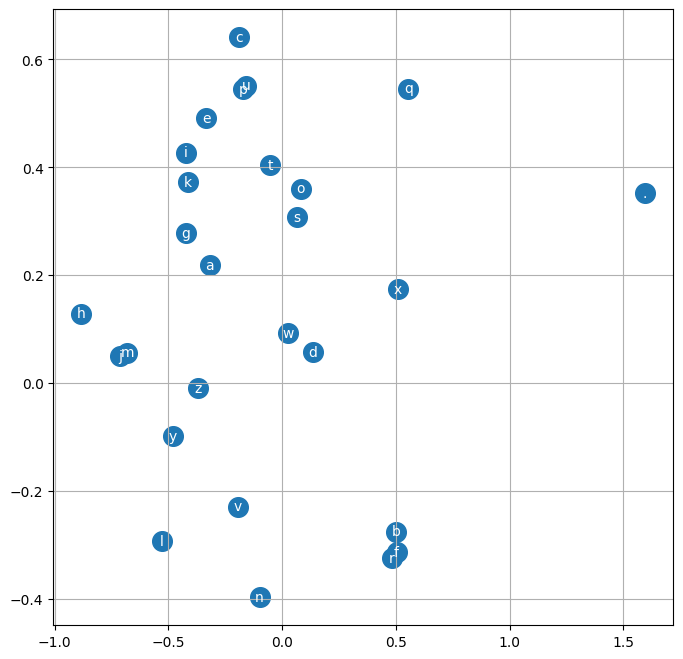

In [36]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(model.C[:, 0].detach().numpy(), model.C[:, 1].detach().numpy(), s=200)
for i in range(model.C.shape[0]):
    plt.text(model.C[i, 0].item(), model.C[i, 1].item(), vocab.itos[i], ha="center", va="center", color='white')
plt.grid(True, which='both')
plt.show()

In [50]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

def sample_from_model(word_count):
    for _ in range(word_count):
        out = []
        context = [0] * Consts.block_size # initialize with all ...
        while True:
            context_tensor = torch.tensor(context) 
            logits = model.forward(context_tensor)
            probs = F.softmax(logits, dim=0) # zmena na dim=0
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        print(''.join(vocab.itos[i] for i in out))

# Test this function
word_count = 20
sample_from_model(word_count)


carpaveato.
hari.
kemriggtef.
khalaysa.
jazonevalee.
rha.
kaeli.
neronia.
chaiiv.
kaleigh.
ham.
pris.
quint.
suline.
liveni.
wazell.
dearyx.
karmeeniveli.
emaediia.
gian.


In [39]:
# sum(p.nelement() for p in parameters) # number of parameters in total